# Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
PVF10_CSVFILE = "../data/processed/structure_pvf_10.csv"

# Chargement et préparation du dataset

## Chargement du fichier csv généré à l'étape d'exploration

In [3]:
import pandas as pd

df_pvf10 = pd.read_csv(PVF10_CSVFILE)

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Type,Largeur,Hauteur,Canaux,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,.png,60,110,3,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,.png,60,110,3,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,.png,60,110,3,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,.png,60,110,3,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,.png,60,110,3,False
...,...,...,...,...,...,...,...,...,...,...
16711,../data/raw/PVF-10\PVF_10_Ori\train\10healthy ...,Ori,train,healthy panel,DJI_20231121165445_0658_T_000004,.tif,69,109,3,False
16712,../data/raw/PVF-10\PVF_10_Ori\train\10healthy ...,Ori,train,healthy panel,DJI_20231121165536_0682_T_000002,.tif,65,110,3,False
16713,../data/raw/PVF-10\PVF_10_Ori\train\10healthy ...,Ori,train,healthy panel,DJI_20231121165610_0698_T_000002,.tif,63,109,3,False
16714,../data/raw/PVF-10\PVF_10_Ori\train\10healthy ...,Ori,train,healthy panel,DJI_20231121165943_0012_T_000003,.tif,70,116,3,False


## Sélection des images au format 110x60

In [4]:
df_pvf10 = df_pvf10.loc[df_pvf10["Format"] == "110x60"].drop(columns=["Canaux", "Type"])

display(df_pvf10)

,Chemin,Format,Train_Test,Classe,Nom,Largeur,Hauteur,Doute_Carre
0,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122654_0466_T_000001,60,110,False
1,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228122803_0500_T_000001,60,110,False
2,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228123425_0666_T_000002,60,110,False
3,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124402_0129_T_000002,60,110,False
4,../data/raw/PVF-10\PVF_10_110x60\test\01substr...,110x60,test,substring open circuit,DJI_20230228124624_0220_T_000001,60,110,False
...,...,...,...,...,...,...,...,...
5567,../data/raw/PVF-10\PVF_10_110x60\train\10healt...,110x60,train,healthy panel,DJI_20231121165445_0658_T_000004,60,110,False
5568,../data/raw/PVF-10\PVF_10_110x60\train\10healt...,110x60,train,healthy panel,DJI_20231121165536_0682_T_000002,60,110,False
5569,../data/raw/PVF-10\PVF_10_110x60\train\10healt...,110x60,train,healthy panel,DJI_20231121165610_0698_T_000002,60,110,False
5570,../data/raw/PVF-10\PVF_10_110x60\train\10healt...,110x60,train,healthy panel,DJI_20231121165943_0012_T_000003,60,110,False


## Chargement des images (objets PVModule)

In [5]:
from pathlib import Path
import cv2
from sep24_cds_pv.features.pvmodule import PVModule

modules = []

for row in df_pvf10.itertuples(index=False):
    
    image_path = Path(row.Chemin)

    img = cv2.imread(image_path) # Récupération de l'image en couleur
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    status = row.Classe
    split = row.Train_Test
    format = row.Format
    
    module = PVModule(image=image_path, 
                    format=format,
                    original_split=split,
                    color_array=img,
                    array=img_gray, 
                    status=status,
                    )
    module.extract_stats()
    module.extract_histogram()

    modules.append(module)

Nombre de modules chargés

In [6]:
print(f"Number of modules: {len(modules)}")

Number of modules: 5572


Affichage du 1er module chargé, pour vérification.

Image: DJI_20230228122654_0466_T_000001
Format: 110x60
Split d'origine: test
Statut: substring open circuit
Taille: 6600
Min/max: 22/239


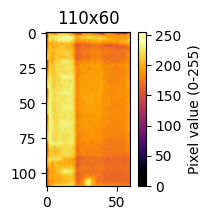

In [7]:
print(modules[0])
modules[0].plot()

## Extraction des features

In [8]:
data = []

for module in modules:

    module_dict = {}

    # ID
    module_dict["id"] = module.image.stem

    # Module's status (target)
    module_dict["status"] = module.status

    # Format
    module_dict["format"] = module.format

    # Original split
    module_dict["original_split"] = module.original_split
    
    # Module's stats
    module_dict.update(module.stats)

    # Histogram values
    histo_dict = {f"hist_{bin_left_edge}": count 
                  for count, bin_left_edge in zip(module.histogram[0], module.histogram[1][:-1])
                  }
    module_dict.update(histo_dict)

    data.append(module_dict)

df = pd.DataFrame.from_records(data)

In [9]:
display(df)

,id,status,format,original_split,mean,median,max,std,min,ptp,...,hist_246,hist_247,hist_248,hist_249,hist_250,hist_251,hist_252,hist_253,hist_254,hist_255
0,DJI_20230228122654_0466_T_000001,substring open circuit,110x60,test,192.039394,189.0,239,22.338687,22,217,...,0,0,0,0,0,0,0,0,0,0
1,DJI_20230228122803_0500_T_000001,substring open circuit,110x60,test,126.448939,125.0,191,31.455054,32,159,...,0,0,0,0,0,0,0,0,0,0
2,DJI_20230228123425_0666_T_000002,substring open circuit,110x60,test,155.861212,158.0,245,37.759745,30,215,...,0,0,0,0,0,0,0,0,0,0
3,DJI_20230228124402_0129_T_000002,substring open circuit,110x60,test,145.170606,143.0,242,48.027035,31,211,...,0,0,0,0,0,0,0,0,0,0
4,DJI_20230228124624_0220_T_000001,substring open circuit,110x60,test,155.635303,153.0,236,36.950789,7,229,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,DJI_20231121165445_0658_T_000004,healthy panel,110x60,train,65.149848,65.0,102,6.115316,13,89,...,0,0,0,0,0,0,0,0,0,0
5568,DJI_20231121165536_0682_T_000002,healthy panel,110x60,train,117.266970,117.0,161,11.372492,38,123,...,0,0,0,0,0,0,0,0,0,0
5569,DJI_20231121165610_0698_T_000002,healthy panel,110x60,train,111.709545,112.0,137,10.205882,55,82,...,0,0,0,0,0,0,0,0,0,0
5570,DJI_20231121165943_0012_T_000003,healthy panel,110x60,train,70.050455,69.0,97,5.653508,29,68,...,0,0,0,0,0,0,0,0,0,0


## Ajout de la colonne 'Doute_Carre'

In [10]:
df = df.merge(df_pvf10[["Nom", "Doute_Carre"]], left_on="id", right_on="Nom").drop(columns="Nom")

## Suppression de la colonne 'size'

La colonne `size`est inutile.

In [11]:
df = df.drop(columns=["size"])

## Suppression des colonnes inutiles

### Colonnes catégorielles

In [12]:
df.select_dtypes(object).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              5572 non-null   object
 1   status          5572 non-null   object
 2   format          5572 non-null   object
 3   original_split  5572 non-null   object
dtypes: object(4)
memory usage: 174.3+ KB


`status` est la colonne cible.

Les autres colonnes `id`, `format` et `original_split` sont à supprimer.


In [13]:
df = df.drop(columns=['id', 'format', 'original_split'])

### Colonnes numériques

On cherche les colonnes numériques du dataframe dont l'écart-type est nul.

In [14]:
zero_std_df = df.describe().loc[:, df.describe().loc["std"] < 0.001]
zero_std_df

,hist_251,hist_252,hist_253,hist_254,hist_255
count,5572.0,5572.0,5572.0,5572.0,5572.0
mean,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0


Ces colonnes n'apportent aucune information. On peut les supprimer.

In [15]:
cols_to_drop = [col for col in zero_std_df.columns]
df = df.drop(columns=cols_to_drop)

# Conversion de la colonne catégorielle 'status'

En colonne numérique (pour XGBoost notamment).

In [16]:
# Classes
status2num = {v: str(i) for i, v in enumerate(df["status"].unique())}

# Conversion de la target (variable catégorielle) en vecteur numérique
df["status"] = df["status"].replace(status2num).astype(int)

In [17]:
status2num

{'substring open circuit': '0',
 'short circuit panel': '1',
 'string short circuit': '2',
 'Debris cover': '3',
 'shadow': '4',
 'bottom dirt': '5',
 'break': '6',
 'junction box heat': '7',
 'hot cell': '8',
 'healthy panel': '9'}

In [18]:
# Dictionnaire pour la conversion numérique -> noms
num2status = {int(v): k for k, v in status2num.items()}

# Séparation du jeu de données

## Choix 'Doute_Carre'

Suppression des images étiquetées 'Doute_Carre'

In [19]:
REMOVE_DOUTE_CARRE = True

if REMOVE_DOUTE_CARRE:
    df = df.loc[df["Doute_Carre"] == False]

# Quoiqu'il en soit, on drop la colonne 'Doute_Carre'
df = df.drop(columns=["Doute_Carre"])

In [20]:
display(df)

,status,mean,median,max,std,min,ptp,skewness,kurtosis,iqr_25_75,...,hist_241,hist_242,hist_243,hist_244,hist_245,hist_246,hist_247,hist_248,hist_249,hist_250
0,0,192.039394,189.0,239,22.338687,22,217,-0.935735,5.150689,30.0,...,0,0,0,0,0,0,0,0,0,0
1,0,126.448939,125.0,191,31.455054,32,159,0.132659,-0.667477,47.0,...,0,0,0,0,0,0,0,0,0,0
2,0,155.861212,158.0,245,37.759745,30,215,-0.264068,-0.224565,45.0,...,5,2,3,1,1,0,0,0,0,0
3,0,145.170606,143.0,242,48.027035,31,211,0.038459,-0.819762,70.0,...,0,1,0,0,0,0,0,0,0,0
4,0,155.635303,153.0,236,36.950789,7,229,-0.128909,-0.225877,49.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,9,65.149848,65.0,102,6.115316,13,89,-0.760941,6.739724,8.0,...,0,0,0,0,0,0,0,0,0,0
5568,9,117.266970,117.0,161,11.372492,38,123,-0.754547,2.901271,12.0,...,0,0,0,0,0,0,0,0,0,0
5569,9,111.709545,112.0,137,10.205882,55,82,-0.221858,1.101500,13.0,...,0,0,0,0,0,0,0,0,0,0
5570,9,70.050455,69.0,97,5.653508,29,68,-0.255933,5.358159,6.0,...,0,0,0,0,0,0,0,0,0,0



Train, Validation & Test.


In [21]:
TRAIN_SIZE = .7
TEST_SIZE = .15
VALIDATION_SIZE = 1. - (TRAIN_SIZE + TEST_SIZE)
RANDOM_STATE = 42
# RANDOM_STATE = None  # Leave random_state to None for non-reproducible shuffling

In [22]:
from sep24_cds_pv.features.model_selection import improved_train_test_validation_split

splits = improved_train_test_validation_split(df, 
                                              target_col="status", 
                                              train_size=TRAIN_SIZE,
                                              validation_size=VALIDATION_SIZE, 
                                              test_size=TEST_SIZE, 
                                              random_state=RANDOM_STATE,
                                              )

In [23]:
total_elements = sum([len(split) for split_name, split in zip(splits._fields, splits) if split_name.startswith("y")])

for split_name, split in zip(splits._fields, splits):
    if not split_name.startswith("y"):
        continue
    print("---------------------------------")
    print(f"Split: {split_name}\n")
    nb_elements = len(split)
    print(f"Nombre d'éléments: {nb_elements}")
    print(f"Proportion du jeu complet: {nb_elements/total_elements*100:.2f}%")
    if not split.empty:
        split_df = pd.DataFrame(pd.Series(split).value_counts())
        split_df["status_name"] = split_df.index.to_series().replace(num2status)
        display(split_df)


---------------------------------
Split: y_train

Nombre d'éléments: 3727
Proportion du jeu complet: 69.82%


,count,status_name
status,,
9,1018,healthy panel
8,591,hot cell
7,559,junction box heat
0,415,substring open circuit
1,298,short circuit panel
5,263,bottom dirt
3,233,Debris cover
4,211,shadow
6,90,break


---------------------------------
Split: y_test

Nombre d'éléments: 804
Proportion du jeu complet: 15.06%


,count,status_name
status,,
9,219,healthy panel
8,127,hot cell
7,120,junction box heat
0,89,substring open circuit
1,64,short circuit panel
5,57,bottom dirt
3,51,Debris cover
4,46,shadow
6,20,break


---------------------------------
Split: y_validation

Nombre d'éléments: 807
Proportion du jeu complet: 15.12%


,count,status_name
status,,
9,219,healthy panel
8,127,hot cell
7,121,junction box heat
0,90,substring open circuit
1,65,short circuit panel
5,57,bottom dirt
3,51,Debris cover
4,46,shadow
6,20,break


In [24]:
if len(splits) == 6:
    X_train, X_test, X_validation, y_train, y_test, y_validation = splits
else:
    X_train, X_test, y_train, y_test = splits

# Modélisation

In [25]:
# Pipeline
# from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline

# Selector
from sklearn.feature_selection import SelectKBest

# Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Resampler
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler

# Modèles à évaluer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


## Configuration du pipeline

In [26]:

# Pipeline générique
pipe = Pipeline([
    ('selector', SelectKBest()),  # Placeholder, remplacé dans la grid
    ('sampler', SMOTE()),  # Placeholder, remplacé dans la grid
    ('scaler', StandardScaler()),  # Placeholder, remplacé dans la grid
    ('model', LogisticRegression())  # Placeholder, remplacé dans la grid
],
memory="./cache_pipeline",
)


In [27]:
import numpy as np

# Paramétrage du sélecteur KBest
selector_param_grid = [
    {
        'selector': [SelectKBest()],
        # 'selector__k' : [50, 100, 150, 200, 'all'],
        'selector__k' : ['all'],
    }
]

# Paramétrage des samplers à évaluer
sampler_param_grid = [
    {
        'sampler': [SMOTE()],
        # 'sampler__k_neighbors': [3, 5, 7],
        # 'sampler__sampling_strategy': ['auto', 0.5],
    },
    {
        'sampler': [ADASYN()],
    },
    {
        'sampler': [RandomOverSampler()],
        'sampler__shrinkage': [0, 0.3],
    },
    {
        'sampler': ['passthrough'],
    }
]

# Paramétrage des scalers à évaluer
scaler_param_grid = [
    {    
        "scaler": [
            MinMaxScaler(),
            StandardScaler(),
            RobustScaler(),
        ]
    }
]

# Dictionnaire des modèles à tester
model_param_grid = [
    {
        'model': [LogisticRegression(max_iter=1000)],
        # 'model__C': [0.1, 1, 10],
        'model__C': [10],
        'model__penalty': ['l2'],
    },
    {
        'model': [SVC()],
        # 'model__C': [0.1, 1, 10],
        # 'model__kernel': ['linear', 'rbf', 'poly'],
        # "model__gamma": ["scale", 0.001, 0.1, 0.5],
        # "model__class_weight": ["balanced", None]
        'model__C': [10],
        'model__kernel': ['rbf'],
        "model__gamma": ["scale"],
        "model__class_weight": [None]
    },
    {
        'model': [KNeighborsClassifier()],
        # "model__n_neighbors": np.arange(2, 20),
        # "model__metric": ["minkowski", "manhattan", "chebyshev"],
        # "model__weights": ["uniform", "distance"],
        # "model__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "model__n_neighbors": [12],
        "model__metric": ["manhattan"],
        "model__weights": ["distance"],
        "model__algorithm": ["auto"],
    },
    {
        'model': [DecisionTreeClassifier()],
        "model__max_depth": [10],
        "model__criterion": ["entropy", "log_loss"],
    },
    # {
    #     'model': [AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     "model__n_estimators": [190],
    #     "model__learning_rate": [1.],
    # },
    # {
    #     'model': [BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5))],
    #     "model__n_estimators": np.arange(100, 500, 100),
    # },
    {
        'model': [RandomForestClassifier()],
        # 'model__n_estimators': np.arange(10, 100, 10),
        # "model__criterion": ["entropy", "gini", "log_loss"],
        # "model__max_depth": np.arange(2, 20),
        'model__n_estimators': [80],
        "model__criterion": ["entropy"],
        "model__max_depth": [18],
    },
    # {
    #     'model': [MLPClassifier(max_iter=10000, alpha=0.0001, early_stopping=True)],
    #     'model__hidden_layer_sizes': [
    #         # (10,),
    #         # (50,),
    #         # (100,),
    #         # (10, 10),
    #         # (50, 50),
    #         (100, 100),
    #         # (10, 10, 10),
    #         # (50, 50, 50),
    #         # (100, 100, 100),
    #         ],
    #     # 'model__solver': ["adam", "lbfgs", "sgd"],
    #     # "model__activation": ["logistic", "tanh", "relu"],
    #     'model__solver': ["lbfgs"],
    #     "model__activation": ["tanh"],
    # },
    {
        'model': [XGBClassifier(eval_metric='logloss', tree_method="hist")],
        # 'model__n_estimators': np.arange(100, 400, 100),
        # 'model__max_depth': np.arange(4, 8, 1),
        # 'model__learning_rate': [0.01, 0.1, 0.3],
        # 'model__subsample': [0.8, 1.0],
        'model__n_estimators': [100],
        'model__max_depth': [7],
        'model__learning_rate': [0.1],
        # 'model__subsample': [0.8, 1.0],
    },
]

# Combinatoire
param_grid = []

for selector_dict in selector_param_grid:
    for sampler_dict in sampler_param_grid:
        for scaler_dict in scaler_param_grid:
            for model_dict in model_param_grid:
                full_dict = {}
                full_dict.update(selector_dict)
                full_dict.update(sampler_dict)
                full_dict.update(scaler_dict)
                full_dict.update(model_dict)
                param_grid.append(full_dict)

In [28]:
len(param_grid)

24

## Exécution du GridSearch


-------------------------------------------------------------------------
Evaluation du pipeline: LogisticRegression_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.40 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegression(max_iter=1000)],
                         'model__C': [10], 'model__penalty': ['l2'],
                         'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': LogisticRegression(max_iter=1000), 'model__C': 10, 'model__penalty': 'l2', 'sampler': SMOTE(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5923252435900863

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


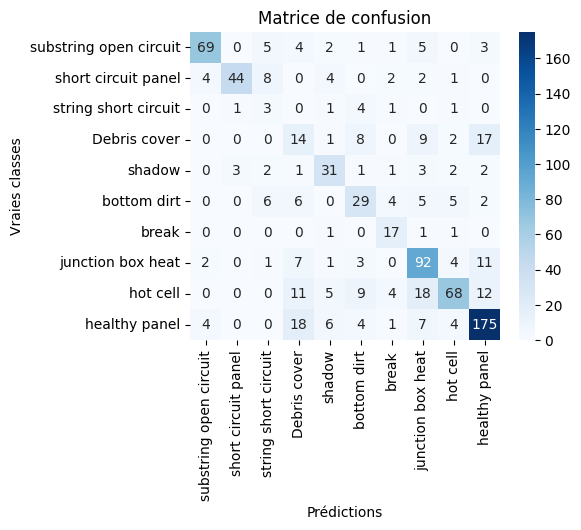

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.87      0.77      0.82        90
   short circuit panel       0.92      0.68      0.78        65
  string short circuit       0.12      0.27      0.17        11
          Debris cover       0.23      0.27      0.25        51
                shadow       0.60      0.67      0.63        46
           bottom dirt       0.49      0.51      0.50        57
                 break       0.55      0.85      0.67        20
     junction box heat       0.65      0.76      0.70       121
              hot cell       0.77      0.54      0.63       127
         healthy panel       0.79      0.80      0.79       219

              accuracy                           0.67       807
             macro avg       0.60      0.61      0.59       807
          weighted avg       0.70      0.67      0.68       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,LogisticRegression_SMOTE,1,"{'model': LogisticRegression(max_iter=1000), '...",8.913425,0.011240,0.677217,0.019639,0.592325,0.024885,0.671623,0.593714,0.679588
1,LogisticRegression_SMOTE,2,"{'model': LogisticRegression(max_iter=1000), '...",11.937952,0.011505,0.618458,0.012588,0.524628,0.022059,NaN,NaN,NaN
2,LogisticRegression_SMOTE,3,"{'model': LogisticRegression(max_iter=1000), '...",12.187273,0.006915,0.533162,0.071650,0.433028,0.059384,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: SVC_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.32 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [SVC()], 'model__C': [10],
                         'model__class_weight': [None],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': SVC(), 'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'sampler': SMOTE(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.6035115105843261

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


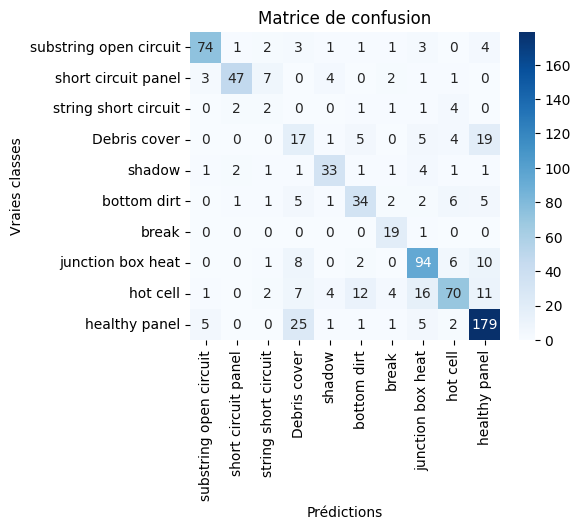

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.88      0.82      0.85        90
   short circuit panel       0.89      0.72      0.80        65
  string short circuit       0.12      0.18      0.15        11
          Debris cover       0.26      0.33      0.29        51
                shadow       0.73      0.72      0.73        46
           bottom dirt       0.60      0.60      0.60        57
                 break       0.61      0.95      0.75        20
     junction box heat       0.71      0.78      0.74       121
              hot cell       0.74      0.55      0.63       127
         healthy panel       0.78      0.82      0.80       219

              accuracy                           0.71       807
             macro avg       0.63      0.65      0.63       807
          weighted avg       0.72      0.71      0.71       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,SVC_SMOTE,1,"{'model': SVC(), 'model__C': 10, 'model__class...",8.446798,1.780242,0.690368,0.017219,0.603512,0.018214,0.705081,0.632847,0.709314
1,SVC_SMOTE,2,"{'model': SVC(), 'model__C': 10, 'model__class...",7.987724,1.670160,0.667827,0.021961,0.573368,0.017832,NaN,NaN,NaN
2,SVC_SMOTE,3,"{'model': SVC(), 'model__C': 10, 'model__class...",9.507548,1.061781,0.335692,0.073856,0.308380,0.093025,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: KNeighborsClassifier_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.04 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [KNeighborsClassifier()],
                         'model__algorithm': ['auto'],
                         'model__metric': ['manhattan'],
                         'model__n_neighbors': [12],
                         'model__weights': ['distance'], 'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': KNeighborsClassifier(), 'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 12, 'model__weights': 'distance', 'sampler': SMOTE(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.49292227184565596

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


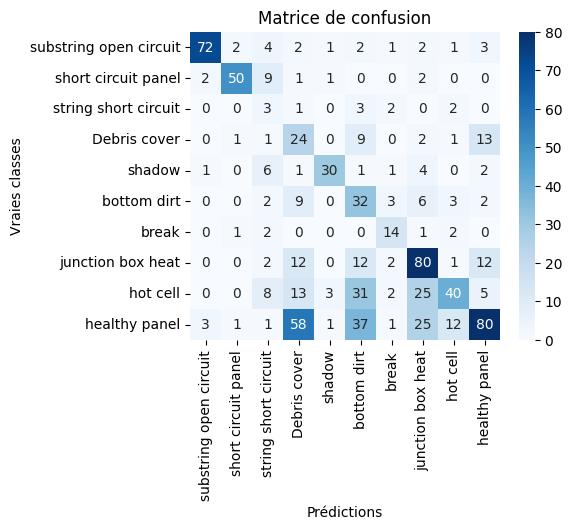

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.92      0.80      0.86        90
   short circuit panel       0.91      0.77      0.83        65
  string short circuit       0.08      0.27      0.12        11
          Debris cover       0.20      0.47      0.28        51
                shadow       0.83      0.65      0.73        46
           bottom dirt       0.25      0.56      0.35        57
                 break       0.54      0.70      0.61        20
     junction box heat       0.54      0.66      0.60       121
              hot cell       0.65      0.31      0.42       127
         healthy panel       0.68      0.37      0.48       219

              accuracy                           0.53       807
             macro avg       0.56      0.56      0.53       807
          weighted avg       0.64      0.53      0.55       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,KNeighborsClassifier_SMOTE,1,"{'model': KNeighborsClassifier(), 'model__algo...",0.194886,1.142493,0.510324,0.022530,0.492922,0.023448,0.526642,0.527671,0.548734
1,KNeighborsClassifier_SMOTE,2,"{'model': KNeighborsClassifier(), 'model__algo...",0.209858,1.180964,0.497980,0.017048,0.491444,0.019000,NaN,NaN,NaN
2,KNeighborsClassifier_SMOTE,3,"{'model': KNeighborsClassifier(), 'model__algo...",0.132238,0.923505,0.488860,0.015558,0.483911,0.020669,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: DecisionTreeClassifier_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.25 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeClassifier()],
                         'model__criterion': ['entropy', 'log_loss'],
                         'model__max_depth': [10], 'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': DecisionTreeClassifier(), 'model__criterion': 'log_loss', 'model__max_depth': 10, 'sampler': SMOTE(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5226512646078625

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


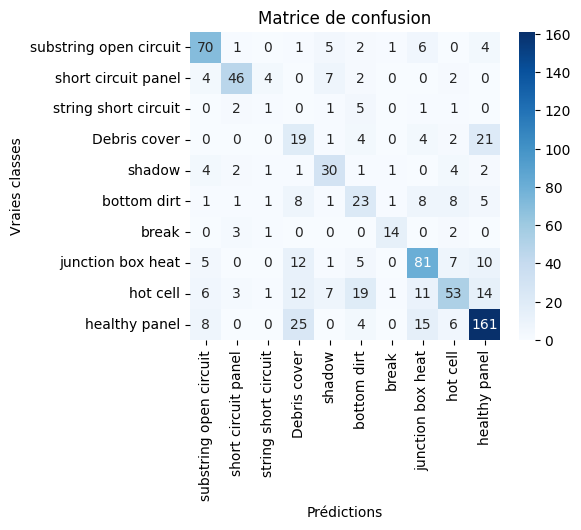

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.71      0.78      0.74        90
   short circuit panel       0.79      0.71      0.75        65
  string short circuit       0.11      0.09      0.10        11
          Debris cover       0.24      0.37      0.29        51
                shadow       0.57      0.65      0.61        46
           bottom dirt       0.35      0.40      0.38        57
                 break       0.78      0.70      0.74        20
     junction box heat       0.64      0.67      0.66       121
              hot cell       0.62      0.42      0.50       127
         healthy panel       0.74      0.74      0.74       219

              accuracy                           0.62       807
             macro avg       0.56      0.55      0.55       807
          weighted avg       0.63      0.62      0.62       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
3,DecisionTreeClassifier_SMOTE,1,"{'model': DecisionTreeClassifier(), 'model__cr...",4.182618,0.008455,0.597001,0.019811,0.522651,0.020936,0.6171,0.550158,0.620159
1,DecisionTreeClassifier_SMOTE,2,"{'model': DecisionTreeClassifier(), 'model__cr...",4.215342,0.010613,0.596466,0.020977,0.520187,0.024267,NaN,NaN,NaN
0,DecisionTreeClassifier_SMOTE,3,"{'model': DecisionTreeClassifier(), 'model__cr...",4.193858,0.009836,0.596468,0.022321,0.519304,0.022166,NaN,NaN,NaN
2,DecisionTreeClassifier_SMOTE,4,"{'model': DecisionTreeClassifier(), 'model__cr...",4.175338,0.006298,0.595125,0.022621,0.517817,0.017438,NaN,NaN,NaN
5,DecisionTreeClassifier_SMOTE,5,"{'model': DecisionTreeClassifier(), 'model__cr...",3.268470,0.007188,0.592173,0.027343,0.515152,0.029315,NaN,NaN,NaN
4,DecisionTreeClassifier_SMOTE,6,"{'model': DecisionTreeClassifier(), 'model__cr...",4.007448,0.006279,0.594588,0.021351,0.513400,0.019669,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: RandomForestClassifier_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.61 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [RandomForestClassifier()],
                         'model__criterion': ['entropy'],
                         'model__max_depth': [18], 'model__n_estimators': [80],
                         'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': RandomForestClassifier(), 'model__criterion': 'entropy', 'model__max_depth': 18, 'model__n_estimators': 80, 'sampler': SMOTE(), 'scaler': RobustScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.6557167818960764

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


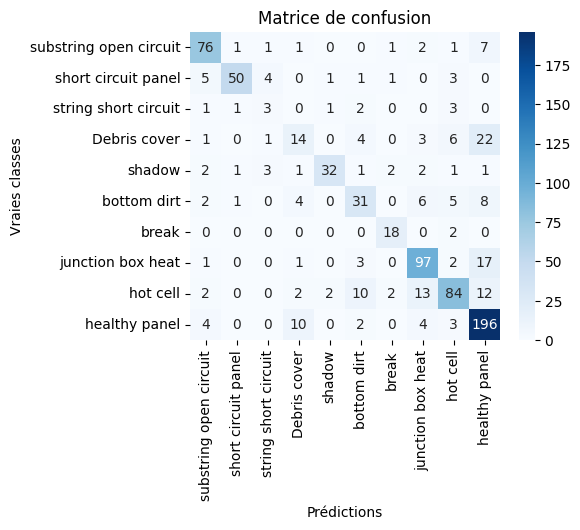

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.81      0.84      0.83        90
   short circuit panel       0.93      0.77      0.84        65
  string short circuit       0.25      0.27      0.26        11
          Debris cover       0.42      0.27      0.33        51
                shadow       0.89      0.70      0.78        46
           bottom dirt       0.57      0.54      0.56        57
                 break       0.75      0.90      0.82        20
     junction box heat       0.76      0.80      0.78       121
              hot cell       0.76      0.66      0.71       127
         healthy panel       0.75      0.89      0.81       219

              accuracy                           0.74       807
             macro avg       0.69      0.67      0.67       807
          weighted avg       0.74      0.74      0.74       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
2,RandomForestClassifier_SMOTE,1,"{'model': RandomForestClassifier(), 'model__cr...",11.787449,0.018010,0.743763,0.016288,0.655717,0.012073,0.744734,0.672225,0.738203
1,RandomForestClassifier_SMOTE,2,"{'model': RandomForestClassifier(), 'model__cr...",14.791652,0.022211,0.741879,0.019371,0.649565,0.022134,NaN,NaN,NaN
0,RandomForestClassifier_SMOTE,3,"{'model': RandomForestClassifier(), 'model__cr...",14.702032,0.022265,0.739465,0.022968,0.642576,0.036415,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: XGBClassifier_SMOTE
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 1.97 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsa...
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None, ...)],
                         'model__learning_rate': [0.1], 'model__max_depth': [7],
                         'model__n_estimators': [100], 'sampler': [SMOTE()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'sampler': SMOTE(), 'scaler': StandardScaler(), 'selecto

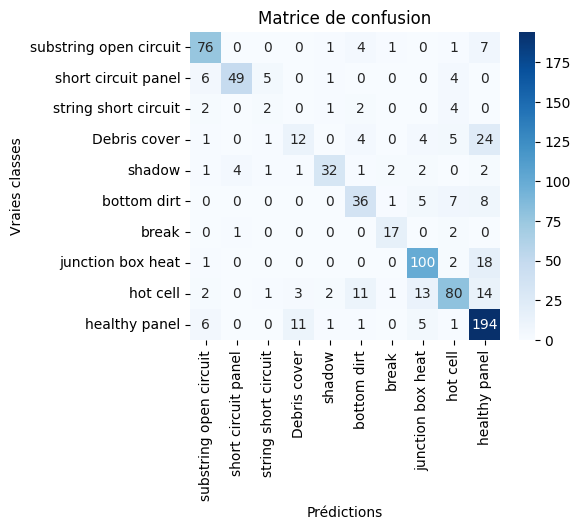

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.80      0.84      0.82        90
   short circuit panel       0.91      0.75      0.82        65
  string short circuit       0.20      0.18      0.19        11
          Debris cover       0.44      0.24      0.31        51
                shadow       0.84      0.70      0.76        46
           bottom dirt       0.61      0.63      0.62        57
                 break       0.77      0.85      0.81        20
     junction box heat       0.78      0.83      0.80       121
              hot cell       0.75      0.63      0.69       127
         healthy panel       0.73      0.89      0.80       219

              accuracy                           0.74       807
             macro avg       0.68      0.65      0.66       807
          weighted avg       0.74      0.74      0.73       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
1,XGBClassifier_SMOTE,1,"{'model': XGBClassifier(base_score=None, boost...",71.120913,0.042899,0.744299,0.022975,0.647686,0.038284,0.741016,0.662049,0.732008
2,XGBClassifier_SMOTE,1,"{'model': XGBClassifier(base_score=None, boost...",49.876300,0.032875,0.744299,0.022975,0.647686,0.038284,NaN,NaN,NaN
0,XGBClassifier_SMOTE,3,"{'model': XGBClassifier(base_score=None, boost...",70.717948,0.043505,0.742957,0.022647,0.646593,0.037787,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: LogisticRegression_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.38 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegression(max_iter=1000)],
                         'model__C': [10], 'model__penalty': ['l2'],
                         'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': LogisticRegression(max_iter=1000), 'model__C': 10, 'model__penalty': 'l2', 'sampler': ADASYN(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5798290492803707

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


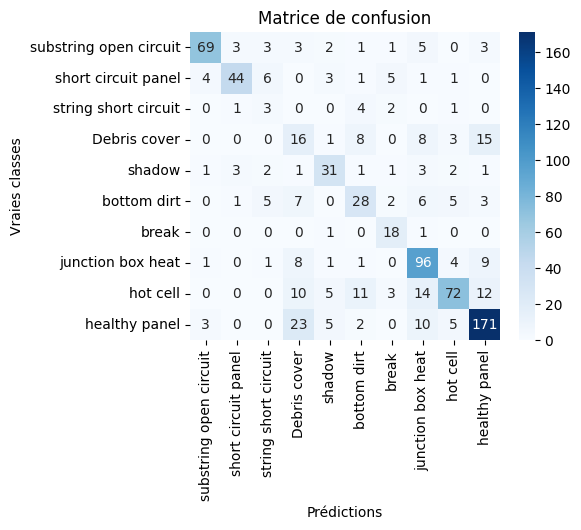

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.88      0.77      0.82        90
   short circuit panel       0.85      0.68      0.75        65
  string short circuit       0.15      0.27      0.19        11
          Debris cover       0.24      0.31      0.27        51
                shadow       0.63      0.67      0.65        46
           bottom dirt       0.49      0.49      0.49        57
                 break       0.56      0.90      0.69        20
     junction box heat       0.67      0.79      0.72       121
              hot cell       0.77      0.57      0.65       127
         healthy panel       0.80      0.78      0.79       219

              accuracy                           0.68       807
             macro avg       0.60      0.62      0.60       807
          weighted avg       0.71      0.68      0.69       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,LogisticRegression_ADASYN,1,"{'model': LogisticRegression(max_iter=1000), '...",9.070814,0.016063,0.667828,0.017379,0.579829,0.023530,0.679058,0.60411,0.686862
1,LogisticRegression_ADASYN,2,"{'model': LogisticRegression(max_iter=1000), '...",12.323565,0.011284,0.610407,0.012074,0.516984,0.018850,NaN,NaN,NaN
2,LogisticRegression_ADASYN,3,"{'model': LogisticRegression(max_iter=1000), '...",12.139408,0.007064,0.551114,0.016213,0.447073,0.017423,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: SVC_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.35 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [SVC()], 'model__C': [10],
                         'model__class_weight': [None],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': SVC(), 'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'sampler': ADASYN(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5999778992200118

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


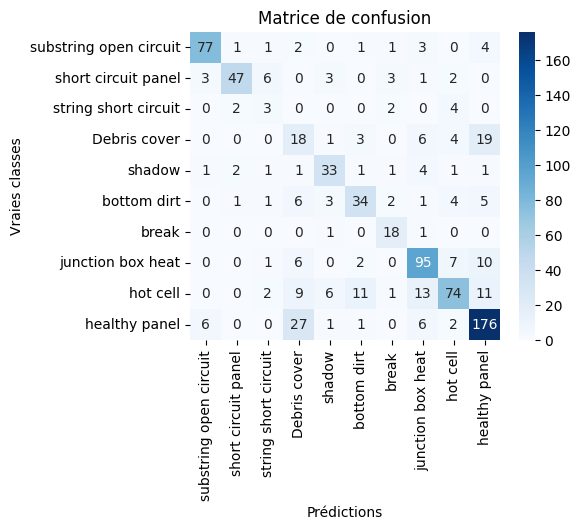

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.89      0.86      0.87        90
   short circuit panel       0.89      0.72      0.80        65
  string short circuit       0.20      0.27      0.23        11
          Debris cover       0.26      0.35      0.30        51
                shadow       0.69      0.72      0.70        46
           bottom dirt       0.64      0.60      0.62        57
                 break       0.64      0.90      0.75        20
     junction box heat       0.73      0.79      0.76       121
              hot cell       0.76      0.58      0.66       127
         healthy panel       0.78      0.80      0.79       219

              accuracy                           0.71       807
             macro avg       0.65      0.66      0.65       807
          weighted avg       0.73      0.71      0.72       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,SVC_ADASYN,1,"{'model': SVC(), 'model__C': 10, 'model__class...",8.529228,1.920894,0.696006,0.020029,0.599978,0.018127,0.712515,0.647351,0.717249
1,SVC_ADASYN,2,"{'model': SVC(), 'model__C': 10, 'model__class...",8.250162,1.744161,0.662196,0.024037,0.570260,0.024940,NaN,NaN,NaN
2,SVC_ADASYN,3,"{'model': SVC(), 'model__C': 10, 'model__class...",10.143113,1.089659,0.367054,0.036702,0.337250,0.032090,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: KNeighborsClassifier_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.04 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [KNeighborsClassifier()],
                         'model__algorithm': ['auto'],
                         'model__metric': ['manhattan'],
                         'model__n_neighbors': [12],
                         'model__weights': ['distance'], 'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': KNeighborsClassifier(), 'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 12, 'model__weights': 'distance', 'sampler': ADASYN(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5009311858769289

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


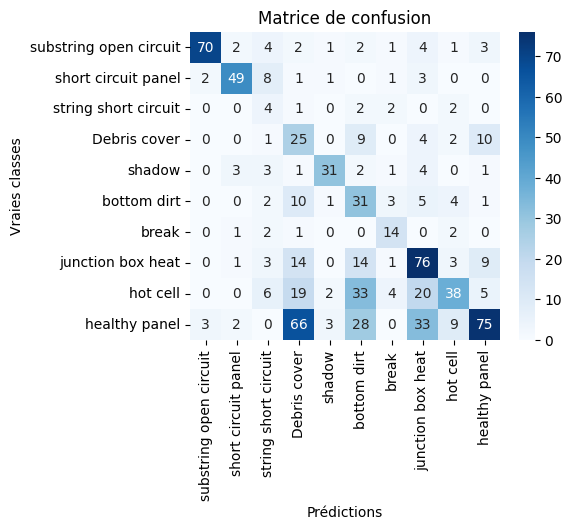

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.93      0.78      0.85        90
   short circuit panel       0.84      0.75      0.80        65
  string short circuit       0.12      0.36      0.18        11
          Debris cover       0.18      0.49      0.26        51
                shadow       0.79      0.67      0.73        46
           bottom dirt       0.26      0.54      0.35        57
                 break       0.52      0.70      0.60        20
     junction box heat       0.51      0.63      0.56       121
              hot cell       0.62      0.30      0.40       127
         healthy panel       0.72      0.34      0.46       219

              accuracy                           0.51       807
             macro avg       0.55      0.56      0.52       807
          weighted avg       0.63      0.51      0.53       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,KNeighborsClassifier_ADASYN,1,"{'model': KNeighborsClassifier(), 'model__algo...",0.218274,1.089144,0.522943,0.018892,0.500931,0.017396,0.511772,0.519392,0.532821
1,KNeighborsClassifier_ADASYN,2,"{'model': KNeighborsClassifier(), 'model__algo...",0.169256,1.120761,0.509256,0.023811,0.498036,0.025720,NaN,NaN,NaN
2,KNeighborsClassifier_ADASYN,3,"{'model': KNeighborsClassifier(), 'model__algo...",0.134186,0.932846,0.496105,0.016174,0.486443,0.022603,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: DecisionTreeClassifier_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.27 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeClassifier()],
                         'model__criterion': ['entropy', 'log_loss'],
                         'model__max_depth': [10], 'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': DecisionTreeClassifier(), 'model__criterion': 'log_loss', 'model__max_depth': 10, 'sampler': ADASYN(), 'scaler': RobustScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5293143753788108

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


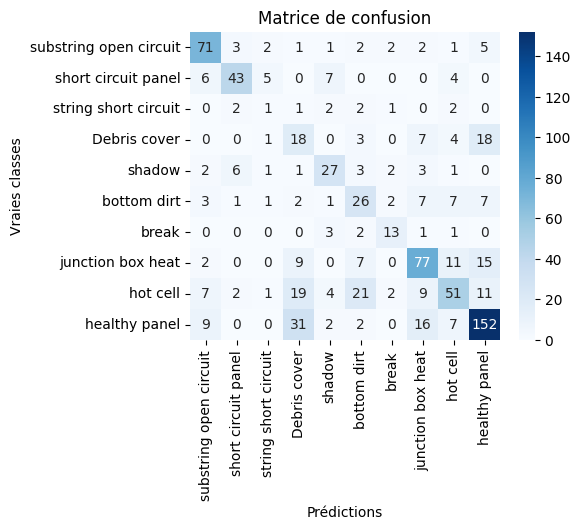

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.71      0.79      0.75        90
   short circuit panel       0.75      0.66      0.70        65
  string short circuit       0.08      0.09      0.09        11
          Debris cover       0.22      0.35      0.27        51
                shadow       0.57      0.59      0.58        46
           bottom dirt       0.38      0.46      0.42        57
                 break       0.59      0.65      0.62        20
     junction box heat       0.63      0.64      0.63       121
              hot cell       0.57      0.40      0.47       127
         healthy panel       0.73      0.69      0.71       219

              accuracy                           0.59       807
             macro avg       0.52      0.53      0.52       807
          weighted avg       0.61      0.59      0.60       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
5,DecisionTreeClassifier_ADASYN,1,"{'model': DecisionTreeClassifier(), 'model__cr...",3.464912,0.005114,0.603428,0.026143,0.529314,0.028327,0.593556,0.524352,0.598783
4,DecisionTreeClassifier_ADASYN,2,"{'model': DecisionTreeClassifier(), 'model__cr...",4.196460,0.009342,0.602888,0.029731,0.527925,0.030290,NaN,NaN,NaN
0,DecisionTreeClassifier_ADASYN,3,"{'model': DecisionTreeClassifier(), 'model__cr...",4.352093,0.009664,0.605571,0.025110,0.525332,0.023334,NaN,NaN,NaN
2,DecisionTreeClassifier_ADASYN,4,"{'model': DecisionTreeClassifier(), 'model__cr...",4.362158,0.006809,0.601278,0.027455,0.524133,0.026245,NaN,NaN,NaN
3,DecisionTreeClassifier_ADASYN,5,"{'model': DecisionTreeClassifier(), 'model__cr...",4.368564,0.009667,0.599135,0.024541,0.518642,0.024562,NaN,NaN,NaN
1,DecisionTreeClassifier_ADASYN,6,"{'model': DecisionTreeClassifier(), 'model__cr...",4.433004,0.009410,0.600472,0.030029,0.517086,0.030020,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: RandomForestClassifier_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.62 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [RandomForestClassifier()],
                         'model__criterion': ['entropy'],
                         'model__max_depth': [18], 'model__n_estimators': [80],
                         'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': RandomForestClassifier(), 'model__criterion': 'entropy', 'model__max_depth': 18, 'model__n_estimators': 80, 'sampler': ADASYN(), 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.6488208095260403

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


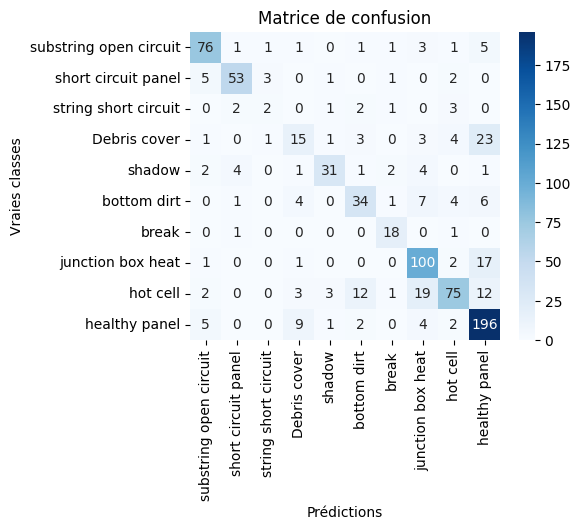

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.83      0.84      0.84        90
   short circuit panel       0.85      0.82      0.83        65
  string short circuit       0.29      0.18      0.22        11
          Debris cover       0.44      0.29      0.35        51
                shadow       0.82      0.67      0.74        46
           bottom dirt       0.62      0.60      0.61        57
                 break       0.72      0.90      0.80        20
     junction box heat       0.71      0.83      0.77       121
              hot cell       0.80      0.59      0.68       127
         healthy panel       0.75      0.89      0.82       219

              accuracy                           0.74       807
             macro avg       0.68      0.66      0.67       807
          weighted avg       0.74      0.74      0.73       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,RandomForestClassifier_ADASYN,1,"{'model': RandomForestClassifier(), 'model__cr...",14.483459,0.022565,0.745104,0.021349,0.648821,0.026214,0.743494,0.66536,0.734279
2,RandomForestClassifier_ADASYN,2,"{'model': RandomForestClassifier(), 'model__cr...",11.863389,0.019392,0.738393,0.017372,0.643632,0.028959,NaN,NaN,NaN
1,RandomForestClassifier_ADASYN,3,"{'model': RandomForestClassifier(), 'model__cr...",14.419657,0.023992,0.740007,0.017603,0.641348,0.022703,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: XGBClassifier_ADASYN
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 2.02 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsa...
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None, ...)],
                         'model__learning_rate': [0.1], 'model__max_depth': [7],
                         'model__n_estimators': [100], 'sampler': [ADASYN()],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'sampler': ADASYN(), 'scaler': MinMaxScaler(), 'selector

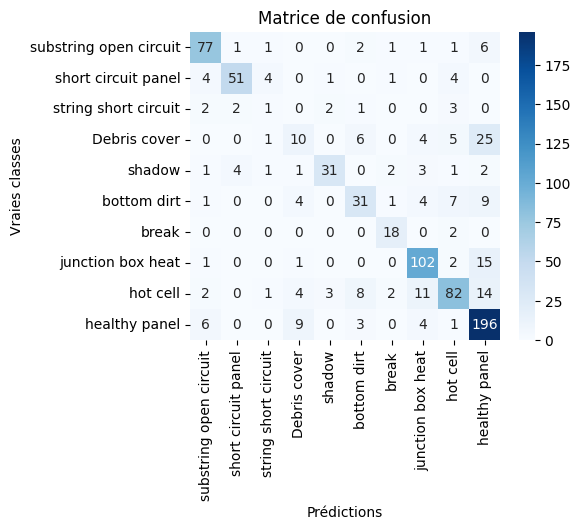

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.82      0.86      0.84        90
   short circuit panel       0.88      0.78      0.83        65
  string short circuit       0.11      0.09      0.10        11
          Debris cover       0.34      0.20      0.25        51
                shadow       0.84      0.67      0.75        46
           bottom dirt       0.61      0.54      0.57        57
                 break       0.72      0.90      0.80        20
     junction box heat       0.79      0.84      0.82       121
              hot cell       0.76      0.65      0.70       127
         healthy panel       0.73      0.89      0.81       219

              accuracy                           0.74       807
             macro avg       0.66      0.64      0.65       807
          weighted avg       0.73      0.74      0.73       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,XGBClassifier_ADASYN,1,"{'model': XGBClassifier(base_score=None, boost...",73.675532,0.047442,0.747248,0.015828,0.652950,0.020558,0.742255,0.645774,0.731313
2,XGBClassifier_ADASYN,1,"{'model': XGBClassifier(base_score=None, boost...",51.314231,0.035199,0.747248,0.015828,0.652950,0.020558,NaN,NaN,NaN
1,XGBClassifier_ADASYN,3,"{'model': XGBClassifier(base_score=None, boost...",73.242884,0.045952,0.747248,0.016148,0.650647,0.019401,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: LogisticRegression_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.58 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegression(max_iter=1000)],
                         'model__C': [10], 'model__penalty': ['l2'],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': LogisticRegression(max_iter=1000), 'model__C': 10, 'model__penalty': 'l2', 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0, 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5767335345522513

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


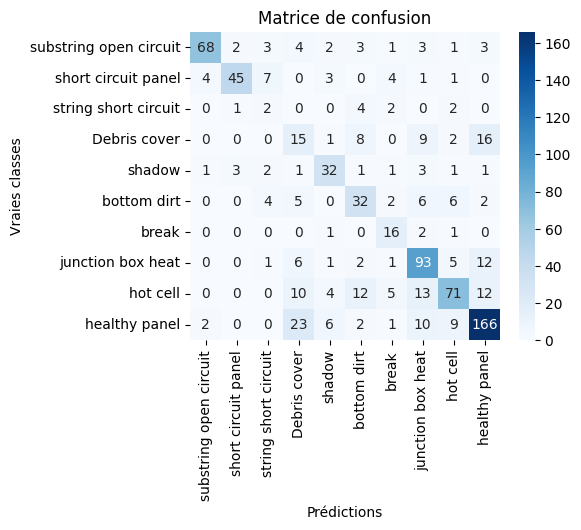

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.91      0.76      0.82        90
   short circuit panel       0.88      0.69      0.78        65
  string short circuit       0.11      0.18      0.13        11
          Debris cover       0.23      0.29      0.26        51
                shadow       0.64      0.70      0.67        46
           bottom dirt       0.50      0.56      0.53        57
                 break       0.48      0.80      0.60        20
     junction box heat       0.66      0.77      0.71       121
              hot cell       0.72      0.56      0.63       127
         healthy panel       0.78      0.76      0.77       219

              accuracy                           0.67       807
             macro avg       0.59      0.61      0.59       807
          weighted avg       0.70      0.67      0.68       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,LogisticRegression_RandomOverSampler,1,"{'model': LogisticRegression(max_iter=1000), '...",9.394429,0.010624,0.664342,0.018928,0.576734,0.019944,0.669145,0.590494,0.677816
3,LogisticRegression_RandomOverSampler,2,"{'model': LogisticRegression(max_iter=1000), '...",8.304380,0.018090,0.660580,0.013635,0.573790,0.017619,NaN,NaN,NaN
4,LogisticRegression_RandomOverSampler,3,"{'model': LogisticRegression(max_iter=1000), '...",5.054298,0.010448,0.633748,0.016441,0.545677,0.019501,NaN,NaN,NaN
1,LogisticRegression_RandomOverSampler,4,"{'model': LogisticRegression(max_iter=1000), '...",12.601468,0.017196,0.609065,0.014916,0.514746,0.017590,NaN,NaN,NaN
5,LogisticRegression_RandomOverSampler,5,"{'model': LogisticRegression(max_iter=1000), '...",12.140296,0.006055,0.585974,0.056525,0.496438,0.048019,NaN,NaN,NaN
2,LogisticRegression_RandomOverSampler,6,"{'model': LogisticRegression(max_iter=1000), '...",16.613476,0.006426,0.564524,0.011906,0.461559,0.019442,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: SVC_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.60 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [SVC()], 'model__C': [10],
                         'model__class_weight': [None],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': SVC(), 'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0, 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.6046430679210388

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


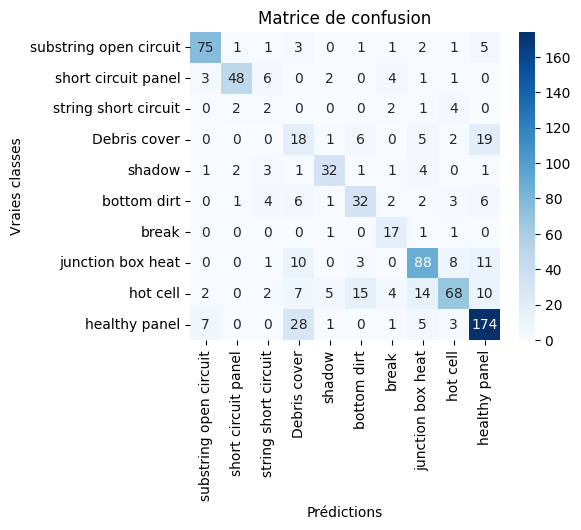

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.85      0.83      0.84        90
   short circuit panel       0.89      0.74      0.81        65
  string short circuit       0.11      0.18      0.13        11
          Debris cover       0.25      0.35      0.29        51
                shadow       0.74      0.70      0.72        46
           bottom dirt       0.55      0.56      0.56        57
                 break       0.53      0.85      0.65        20
     junction box heat       0.72      0.73      0.72       121
              hot cell       0.75      0.54      0.62       127
         healthy panel       0.77      0.79      0.78       219

              accuracy                           0.69       807
             macro avg       0.62      0.63      0.61       807
          weighted avg       0.71      0.69      0.69       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,SVC_RandomOverSampler,1,"{'model': SVC(), 'model__C': 10, 'model__class...",8.593117,1.952162,0.691707,0.011205,0.604643,0.008899,0.686493,0.612973,0.694177
3,SVC_RandomOverSampler,2,"{'model': SVC(), 'model__C': 10, 'model__class...",9.943571,2.249538,0.687953,0.020279,0.600379,0.021977,NaN,NaN,NaN
4,SVC_RandomOverSampler,3,"{'model': SVC(), 'model__C': 10, 'model__class...",8.508382,1.819846,0.670512,0.025765,0.576965,0.022796,NaN,NaN,NaN
1,SVC_RandomOverSampler,4,"{'model': SVC(), 'model__C': 10, 'model__class...",7.230596,1.544993,0.659778,0.023686,0.568666,0.020667,NaN,NaN,NaN
2,SVC_RandomOverSampler,5,"{'model': SVC(), 'model__C': 10, 'model__class...",15.829052,2.340745,0.418293,0.010397,0.383329,0.020772,NaN,NaN,NaN
5,SVC_RandomOverSampler,6,"{'model': SVC(), 'model__C': 10, 'model__class...",8.607173,0.977225,0.338866,0.039704,0.294421,0.041104,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: KNeighborsClassifier_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.05 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [KNeighborsClassifier()],
                         'model__algorithm': ['auto'],
                         'model__metric': ['manhattan'],
                         'model__n_neighbors': [12],
                         'model__weights': ['distance'],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': KNeighborsClassifier(), 'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 12, 'model__weights': 'distance', 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0.3, 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5061030828265491

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


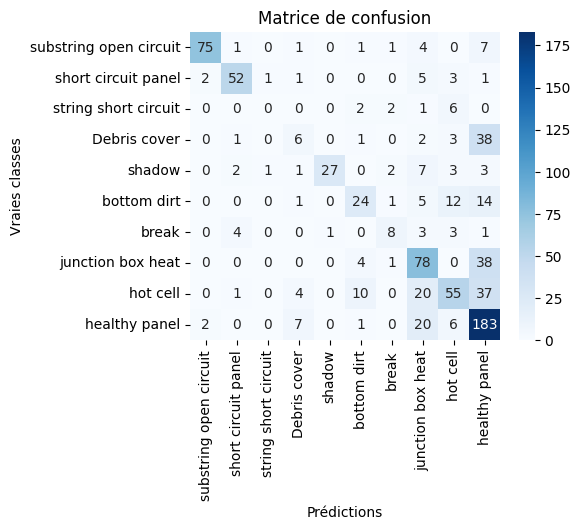

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.95      0.83      0.89        90
   short circuit panel       0.85      0.80      0.83        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.29      0.12      0.17        51
                shadow       0.96      0.59      0.73        46
           bottom dirt       0.56      0.42      0.48        57
                 break       0.53      0.40      0.46        20
     junction box heat       0.54      0.64      0.59       121
              hot cell       0.60      0.43      0.50       127
         healthy panel       0.57      0.84      0.68       219

              accuracy                           0.63       807
             macro avg       0.59      0.51      0.53       807
          weighted avg       0.63      0.63      0.61       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
3,KNeighborsClassifier_RandomOverSampler,1,"{'model': KNeighborsClassifier(), 'model__algo...",0.094774,0.930596,0.617650,0.017153,0.506103,0.029900,0.629492,0.531409,0.613763
4,KNeighborsClassifier_RandomOverSampler,2,"{'model': KNeighborsClassifier(), 'model__algo...",0.087574,0.928629,0.603163,0.017345,0.500023,0.032997,NaN,NaN,NaN
5,KNeighborsClassifier_RandomOverSampler,3,"{'model': KNeighborsClassifier(), 'model__algo...",0.094410,0.824834,0.575255,0.015626,0.488487,0.017293,NaN,NaN,NaN
0,KNeighborsClassifier_RandomOverSampler,4,"{'model': KNeighborsClassifier(), 'model__algo...",0.107172,0.951249,0.512474,0.023164,0.485393,0.021498,NaN,NaN,NaN
1,KNeighborsClassifier_RandomOverSampler,5,"{'model': KNeighborsClassifier(), 'model__algo...",0.107535,0.931452,0.494765,0.010831,0.478560,0.007624,NaN,NaN,NaN
2,KNeighborsClassifier_RandomOverSampler,6,"{'model': KNeighborsClassifier(), 'model__algo...",0.090899,0.932203,0.477319,0.015523,0.470076,0.021093,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: DecisionTreeClassifier_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Temps nécessaire : 0.38 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeClassifier()],
                         'model__criterion': ['entropy', 'log_loss'],
                         'model__max_depth': [10],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': DecisionTreeClassifier(), 'model__criterion': 'entropy', 'model__max_depth': 10, 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0.3, 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5119558676449842

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


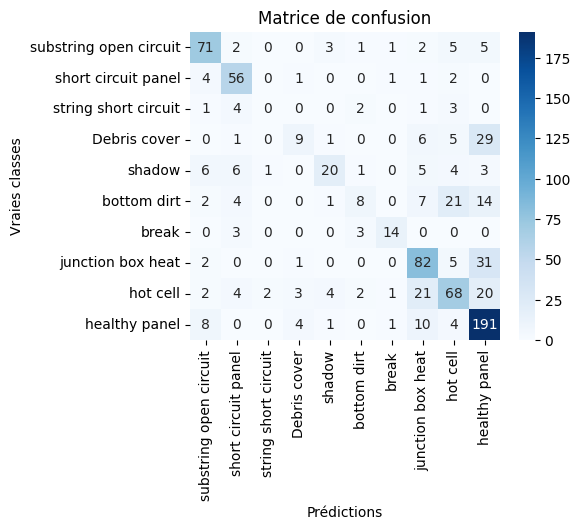

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.74      0.79      0.76        90
   short circuit panel       0.70      0.86      0.77        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.50      0.18      0.26        51
                shadow       0.67      0.43      0.53        46
           bottom dirt       0.47      0.14      0.22        57
                 break       0.78      0.70      0.74        20
     junction box heat       0.61      0.68      0.64       121
              hot cell       0.58      0.54      0.56       127
         healthy panel       0.65      0.87      0.75       219

              accuracy                           0.64       807
             macro avg       0.57      0.52      0.52       807
          weighted avg       0.62      0.64      0.61       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
3,DecisionTreeClassifier_RandomOverSampler,1,"{'model': DecisionTreeClassifier(), 'model__cr...",5.455270,0.007981,0.629993,0.029670,0.511956,0.041062,0.643123,0.522019,0.613618
11,DecisionTreeClassifier_RandomOverSampler,2,"{'model': DecisionTreeClassifier(), 'model__cr...",4.304729,0.005884,0.629184,0.031172,0.508775,0.041943,NaN,NaN,NaN
10,DecisionTreeClassifier_RandomOverSampler,3,"{'model': DecisionTreeClassifier(), 'model__cr...",5.276059,0.009347,0.629454,0.030379,0.505674,0.042610,NaN,NaN,NaN
9,DecisionTreeClassifier_RandomOverSampler,4,"{'model': DecisionTreeClassifier(), 'model__cr...",5.398083,0.007717,0.627843,0.031102,0.505372,0.040212,NaN,NaN,NaN
5,DecisionTreeClassifier_RandomOverSampler,5,"{'model': DecisionTreeClassifier(), 'model__cr...",5.402506,0.006887,0.628113,0.028480,0.504048,0.035837,NaN,NaN,NaN
4,DecisionTreeClassifier_RandomOverSampler,6,"{'model': DecisionTreeClassifier(), 'model__cr...",5.419403,0.011321,0.627307,0.028672,0.502576,0.033803,NaN,NaN,NaN
1,DecisionTreeClassifier_RandomOverSampler,7,"{'model': DecisionTreeClassifier(), 'model__cr...",1.107931,0.007783,0.569354,0.029603,0.491547,0.030374,NaN,NaN,NaN
7,DecisionTreeClassifier_RandomOverSampler,8,"{'model': DecisionTreeClassifier(), 'model__cr...",1.057872,0.008754,0.568011,0.024917,0.491439,0.023393,NaN,NaN,NaN
0,DecisionTreeClassifier_RandomOverSampler,9,"{'model': DecisionTreeClassifier(), 'model__cr...",1.123563,0.010259,0.566133,0.026108,0.490500,0.028288,NaN,NaN,NaN
8,DecisionTreeClassifier_RandomOverSampler,10,"{'model': DecisionTreeClassifier(), 'model__cr...",1.046254,0.009904,0.566668,0.025444,0.488503,0.026542,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: RandomForestClassifier_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.72 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [RandomForestClassifier()],
                         'model__criterion': ['entropy'],
                         'model__max_depth': [18], 'model__n_estimators': [80],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': RandomForestClassifier(), 'model__criterion': 'entropy', 'model__max_depth': 18, 'model__n_estimators': 80, 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0, 'scaler': StandardScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.636811296772853

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


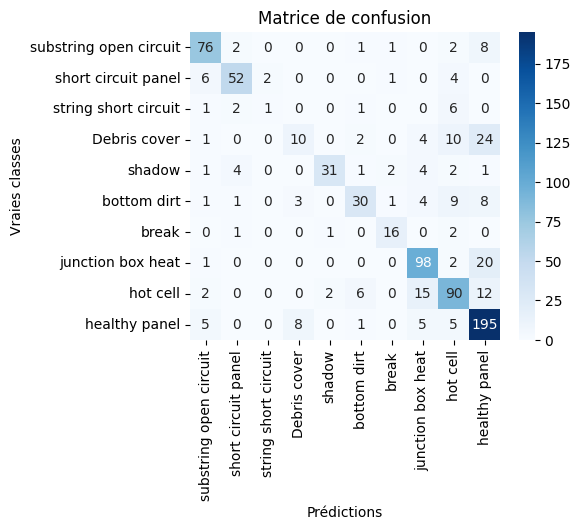

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.81      0.84      0.83        90
   short circuit panel       0.84      0.80      0.82        65
  string short circuit       0.33      0.09      0.14        11
          Debris cover       0.48      0.20      0.28        51
                shadow       0.91      0.67      0.78        46
           bottom dirt       0.71      0.53      0.61        57
                 break       0.76      0.80      0.78        20
     junction box heat       0.75      0.81      0.78       121
              hot cell       0.68      0.71      0.69       127
         healthy panel       0.73      0.89      0.80       219

              accuracy                           0.74       807
             macro avg       0.70      0.63      0.65       807
          weighted avg       0.73      0.74      0.73       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
1,RandomForestClassifier_RandomOverSampler,1,"{'model': RandomForestClassifier(), 'model__cr...",4.869817,0.022040,0.750468,0.017351,0.636811,0.033300,0.742255,0.650385,0.727693
2,RandomForestClassifier_RandomOverSampler,2,"{'model': RandomForestClassifier(), 'model__cr...",4.686433,0.020680,0.746177,0.018918,0.634790,0.030056,NaN,NaN,NaN
0,RandomForestClassifier_RandomOverSampler,3,"{'model': RandomForestClassifier(), 'model__cr...",4.898031,0.020925,0.745907,0.021390,0.625136,0.022026,NaN,NaN,NaN
5,RandomForestClassifier_RandomOverSampler,4,"{'model': RandomForestClassifier(), 'model__cr...",15.898028,0.014631,0.734638,0.022654,0.622745,0.033990,NaN,NaN,NaN
4,RandomForestClassifier_RandomOverSampler,5,"{'model': RandomForestClassifier(), 'model__cr...",19.502110,0.024123,0.734103,0.020338,0.615813,0.032968,NaN,NaN,NaN
3,RandomForestClassifier_RandomOverSampler,6,"{'model': RandomForestClassifier(), 'model__cr...",19.723582,0.021370,0.735176,0.024749,0.615115,0.038382,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: XGBClassifier_RandomOverSampler
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 2.24 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsa...
                                                 num_parallel_tree=None, ...)],
                         'model__learning_rate': [0.1], 'model__max_depth': [7],
                         'model__n_estimators': [100],
                         'sampler': [RandomOverSampler()],
                         'sampler__shrinkage': [0, 0.3],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'sampler': RandomOverSampler(), 'sampler__shrinkage': 0,

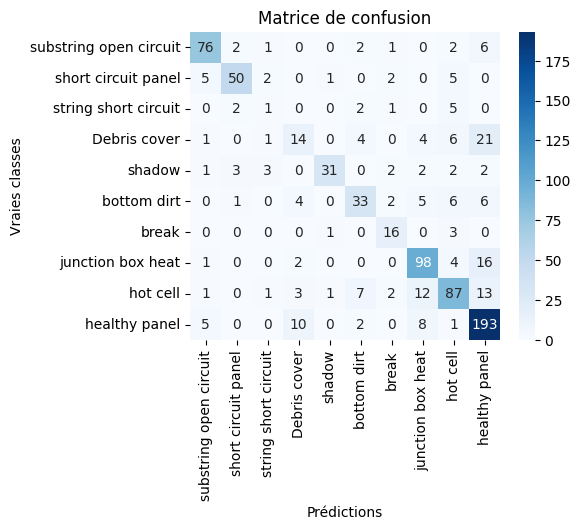

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.84      0.84      0.84        90
   short circuit panel       0.86      0.77      0.81        65
  string short circuit       0.11      0.09      0.10        11
          Debris cover       0.42      0.27      0.33        51
                shadow       0.91      0.67      0.78        46
           bottom dirt       0.66      0.58      0.62        57
                 break       0.62      0.80      0.70        20
     junction box heat       0.76      0.81      0.78       121
              hot cell       0.72      0.69      0.70       127
         healthy panel       0.75      0.88      0.81       219

              accuracy                           0.74       807
             macro avg       0.67      0.64      0.65       807
          weighted avg       0.74      0.74      0.74       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,XGBClassifier_RandomOverSampler,1,"{'model': XGBClassifier(base_score=None, boost...",40.711942,0.043397,0.745910,0.022733,0.639176,0.035925,0.742255,0.64748,0.735104
1,XGBClassifier_RandomOverSampler,1,"{'model': XGBClassifier(base_score=None, boost...",40.561896,0.040160,0.745910,0.022733,0.639176,0.035925,NaN,NaN,NaN
2,XGBClassifier_RandomOverSampler,1,"{'model': XGBClassifier(base_score=None, boost...",39.315496,0.043520,0.745910,0.022733,0.639176,0.035925,NaN,NaN,NaN
4,XGBClassifier_RandomOverSampler,4,"{'model': XGBClassifier(base_score=None, boost...",51.428436,0.044026,0.747788,0.015077,0.636821,0.027390,NaN,NaN,NaN
5,XGBClassifier_RandomOverSampler,5,"{'model': XGBClassifier(base_score=None, boost...",36.013435,0.023346,0.747252,0.015760,0.636719,0.027507,NaN,NaN,NaN
3,XGBClassifier_RandomOverSampler,6,"{'model': XGBClassifier(base_score=None, boost...",54.393612,0.039067,0.748861,0.015904,0.635298,0.025018,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: LogisticRegression_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.12 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [LogisticRegression(max_iter=1000)],
                         'model__C': [10], 'model__penalty': ['l2'],
                         'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': LogisticRegression(max_iter=1000), 'model__C': 10, 'model__penalty': 'l2', 'sampler': 'passthrough', 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5789388801389606

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


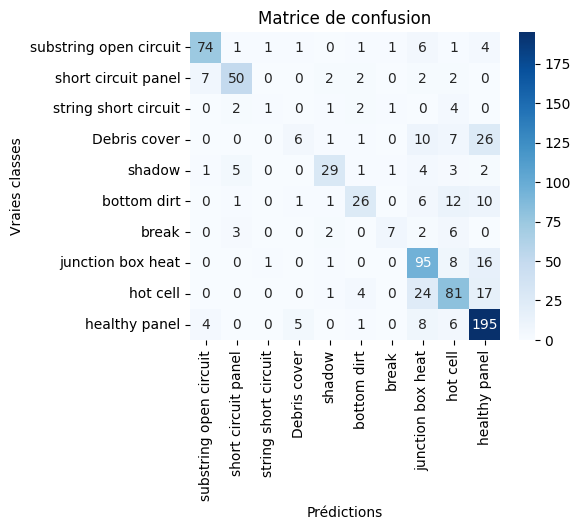

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.86      0.82      0.84        90
   short circuit panel       0.81      0.77      0.79        65
  string short circuit       0.33      0.09      0.14        11
          Debris cover       0.46      0.12      0.19        51
                shadow       0.76      0.63      0.69        46
           bottom dirt       0.68      0.46      0.55        57
                 break       0.70      0.35      0.47        20
     junction box heat       0.61      0.79      0.68       121
              hot cell       0.62      0.64      0.63       127
         healthy panel       0.72      0.89      0.80       219

              accuracy                           0.70       807
             macro avg       0.66      0.55      0.58       807
          weighted avg       0.69      0.70      0.68       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,LogisticRegression_noSampling,1,"{'model': LogisticRegression(max_iter=1000), '...",2.911983,0.010793,0.707806,0.017395,0.578939,0.025509,0.698885,0.577453,0.678695
1,LogisticRegression_noSampling,2,"{'model': LogisticRegression(max_iter=1000), '...",3.863213,0.006892,0.646093,0.019118,0.530846,0.026672,NaN,NaN,NaN
2,LogisticRegression_noSampling,3,"{'model': LogisticRegression(max_iter=1000), '...",4.090515,0.007980,0.610133,0.025303,0.477379,0.029749,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: SVC_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.06 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [SVC()], 'model__C': [10],
                         'model__class_weight': [None],
                         'model__gamma': ['scale'], 'model__kernel': ['rbf'],
                         'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': SVC(), 'model__C': 10, 'model__class_weight': None, 'model__gamma': 'scale', 'model__kernel': 'rbf', 'sampler': 'passthrough', 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.5807684301870067

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


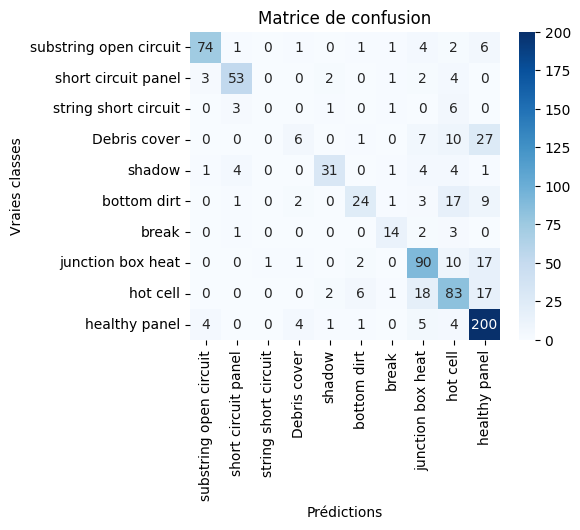

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.90      0.82      0.86        90
   short circuit panel       0.84      0.82      0.83        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.43      0.12      0.18        51
                shadow       0.84      0.67      0.75        46
           bottom dirt       0.69      0.42      0.52        57
                 break       0.70      0.70      0.70        20
     junction box heat       0.67      0.74      0.70       121
              hot cell       0.58      0.65      0.61       127
         healthy panel       0.72      0.91      0.81       219

              accuracy                           0.71       807
             macro avg       0.64      0.59      0.60       807
          weighted avg       0.70      0.71      0.69       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,SVC_noSampling,1,"{'model': SVC(), 'model__C': 10, 'model__class...",0.950292,0.681202,0.711293,0.025571,0.580768,0.028982,0.712515,0.596632,0.692142
1,SVC_noSampling,2,"{'model': SVC(), 'model__C': 10, 'model__class...",1.291575,0.691537,0.689560,0.024601,0.567006,0.029929,NaN,NaN,NaN
2,SVC_noSampling,3,"{'model': SVC(), 'model__C': 10, 'model__class...",0.973896,0.470712,0.506308,0.018870,0.412099,0.031013,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: KNeighborsClassifier_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.02 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [KNeighborsClassifier()],
                         'model__algorithm': ['auto'],
                         'model__metric': ['manhattan'],
                         'model__n_neighbors': [12],
                         'model__weights': ['distance'],
                         'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': KNeighborsClassifier(), 'model__algorithm': 'auto', 'model__metric': 'manhattan', 'model__n_neighbors': 12, 'model__weights': 'distance', 'sampler': 'passthrough', 'scaler': MinMaxScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.49470282802669907

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


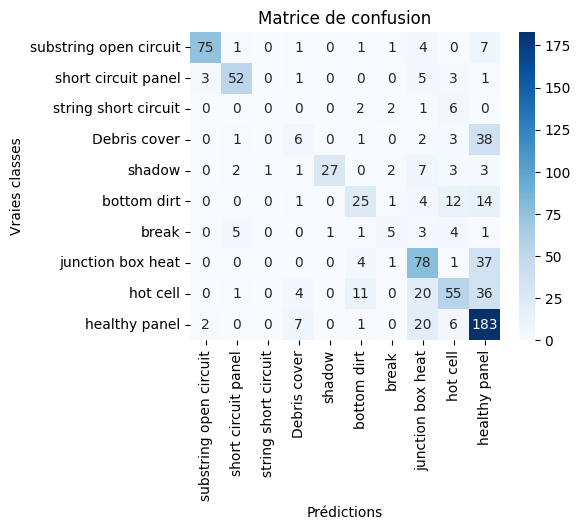

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.94      0.83      0.88        90
   short circuit panel       0.84      0.80      0.82        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.29      0.12      0.17        51
                shadow       0.96      0.59      0.73        46
           bottom dirt       0.54      0.44      0.49        57
                 break       0.42      0.25      0.31        20
     junction box heat       0.54      0.64      0.59       121
              hot cell       0.59      0.43      0.50       127
         healthy panel       0.57      0.84      0.68       219

              accuracy                           0.63       807
             macro avg       0.57      0.49      0.52       807
          weighted avg       0.62      0.63      0.61       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,KNeighborsClassifier_noSampling,1,"{'model': KNeighborsClassifier(), 'model__algo...",0.059337,0.368289,0.615502,0.018521,0.494703,0.026219,0.627014,0.51633,0.609748
1,KNeighborsClassifier_noSampling,2,"{'model': KNeighborsClassifier(), 'model__algo...",0.058505,0.364316,0.600479,0.017719,0.487358,0.030695,NaN,NaN,NaN
2,KNeighborsClassifier_noSampling,3,"{'model': KNeighborsClassifier(), 'model__algo...",0.050337,0.307620,0.581963,0.015214,0.479986,0.028036,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: DecisionTreeClassifier_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Temps nécessaire : 0.05 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [DecisionTreeClassifier()],
                         'model__criterion': ['entropy', 'log_loss'],
                         'model__max_depth': [10], 'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': DecisionTreeClassifier(), 'model__criterion': 'log_loss', 'model__max_depth': 10, 'sampler': 'passthrough', 'scaler': RobustScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.535455739995603

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


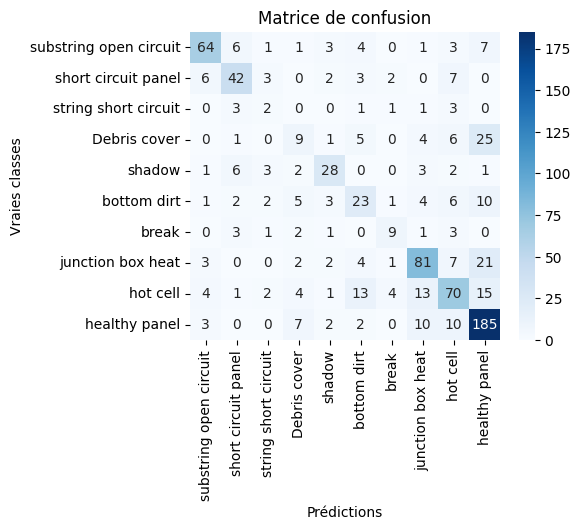

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.78      0.71      0.74        90
   short circuit panel       0.66      0.65      0.65        65
  string short circuit       0.14      0.18      0.16        11
          Debris cover       0.28      0.18      0.22        51
                shadow       0.65      0.61      0.63        46
           bottom dirt       0.42      0.40      0.41        57
                 break       0.50      0.45      0.47        20
     junction box heat       0.69      0.67      0.68       121
              hot cell       0.60      0.55      0.57       127
         healthy panel       0.70      0.84      0.77       219

              accuracy                           0.64       807
             macro avg       0.54      0.52      0.53       807
          weighted avg       0.63      0.64      0.63       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
5,DecisionTreeClassifier_noSampling,1,"{'model': DecisionTreeClassifier(), 'model__cr...",0.573062,0.004539,0.641256,0.020899,0.535456,0.025634,0.635688,0.530347,0.627758
1,DecisionTreeClassifier_noSampling,2,"{'model': DecisionTreeClassifier(), 'model__cr...",0.948076,0.009615,0.640184,0.021161,0.533902,0.029649,NaN,NaN,NaN
4,DecisionTreeClassifier_noSampling,3,"{'model': DecisionTreeClassifier(), 'model__cr...",0.674934,0.006017,0.639649,0.019743,0.533417,0.035238,NaN,NaN,NaN
0,DecisionTreeClassifier_noSampling,4,"{'model': DecisionTreeClassifier(), 'model__cr...",0.945091,0.006412,0.642062,0.022913,0.527277,0.035787,NaN,NaN,NaN
2,DecisionTreeClassifier_noSampling,5,"{'model': DecisionTreeClassifier(), 'model__cr...",0.784804,0.009569,0.639109,0.024509,0.523744,0.034353,NaN,NaN,NaN
3,DecisionTreeClassifier_noSampling,6,"{'model': DecisionTreeClassifier(), 'model__cr...",0.698098,0.008031,0.640720,0.019876,0.523344,0.029838,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: RandomForestClassifier_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.12 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [RandomForestClassifier()],
                         'model__criterion': ['entropy'],
                         'model__max_depth': [18], 'model__n_estimators': [80],
                         'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': RandomForestClassifier(), 'model__criterion': 'entropy', 'model__max_depth': 18, 'model__n_estimators': 80, 'sampler': 'passthrough', 'scaler': RobustScaler(), 'selector': SelectKBest(), 'selector__k': 'all'}
Meilleur score (f1 macro):  0.601202393509091

Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:


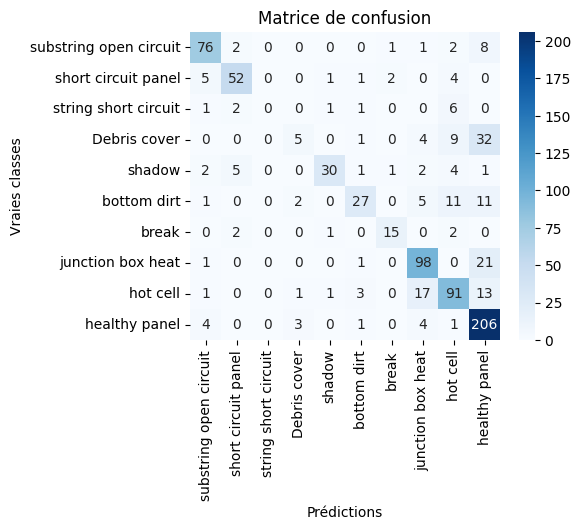

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.84      0.84      0.84        90
   short circuit panel       0.83      0.80      0.81        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.45      0.10      0.16        51
                shadow       0.88      0.65      0.75        46
           bottom dirt       0.75      0.47      0.58        57
                 break       0.79      0.75      0.77        20
     junction box heat       0.75      0.81      0.78       121
              hot cell       0.70      0.72      0.71       127
         healthy panel       0.71      0.94      0.81       219

              accuracy                           0.74       807
             macro avg       0.67      0.61      0.62       807
          weighted avg       0.72      0.74      0.72       807



e:\Miniconda3\envs\DataScientist_Projet_Git\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Miniconda3\envs\DataScientist_Projet_Git\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Miniconda3\envs\DataScientist_Projet_Git\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
2,RandomForestClassifier_noSampling,1,"{'model': RandomForestClassifier(), 'model__cr...",2.287984,0.014649,0.738125,0.024668,0.601202,0.037702,0.743494,0.620566,0.718984
1,RandomForestClassifier_noSampling,2,"{'model': RandomForestClassifier(), 'model__cr...",2.782283,0.023338,0.740272,0.022720,0.599209,0.030079,NaN,NaN,NaN
0,RandomForestClassifier_noSampling,3,"{'model': RandomForestClassifier(), 'model__cr...",2.788595,0.019170,0.739464,0.019607,0.597227,0.018007,NaN,NaN,NaN



-------------------------------------------------------------------------
Evaluation du pipeline: XGBClassifier_noSampling
-------------------------------------------------------------------------

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Temps nécessaire : 0.89 minutes


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(memory='./cache_pipeline',
                                steps=[('selector', SelectKBest()),
                                       ('sampler', SMOTE()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'model': [XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsa...
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None, ...)],
                         'model__learning_rate': [0.1], 'model__max_depth': [7],
                         'model__n_estimators': [100],
                         'sampler': ['passthrough'],
                         'scaler': [MinMaxScaler(), StandardScaler(),
                                    RobustScaler()],
                         'selector': [SelectKBest()], 'selector__k': ['all']},
             refit='f1_macro',
             scoring={'accuracy': 'accuracy', 'f1_macro': 'f1_macro'},
             verbose=2)


Résultats obtenus par le GridSearch:
Meilleurs paramètres (f1 macro) :  {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...), 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 100, 'sampler': 'passthrough', 'scaler': MinMaxScaler(), 'sel

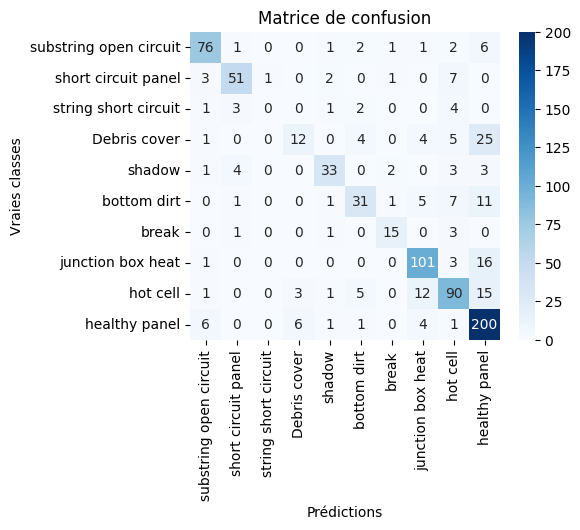

Rapport de classification :
                         precision    recall  f1-score   support

substring open circuit       0.84      0.84      0.84        90
   short circuit panel       0.84      0.78      0.81        65
  string short circuit       0.00      0.00      0.00        11
          Debris cover       0.57      0.24      0.33        51
                shadow       0.80      0.72      0.76        46
           bottom dirt       0.69      0.54      0.61        57
                 break       0.75      0.75      0.75        20
     junction box heat       0.80      0.83      0.81       121
              hot cell       0.72      0.71      0.71       127
         healthy panel       0.72      0.91      0.81       219

              accuracy                           0.75       807
             macro avg       0.67      0.63      0.64       807
          weighted avg       0.74      0.75      0.74       807



,pipeline_id,rank_test_f1_macro,params,mean_fit_time,mean_score_time,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,validation_accuracy,validation_f1_macro,validation_f1_weighted
0,XGBClassifier_noSampling,1,"{'model': XGBClassifier(base_score=None, boost...",32.925346,0.052584,0.750203,0.02274,0.627547,0.037021,0.754647,0.644065,0.739037
1,XGBClassifier_noSampling,1,"{'model': XGBClassifier(base_score=None, boost...",33.200444,0.045035,0.750203,0.02274,0.627547,0.037021,NaN,NaN,NaN
2,XGBClassifier_noSampling,1,"{'model': XGBClassifier(base_score=None, boost...",22.783263,0.027463,0.750203,0.02274,0.627547,0.037021,NaN,NaN,NaN


In [29]:
import time
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sep24_cds_pv.features.model_selection import display_results


# Extraire le type de modèle
def extract_model_name(param_dict):
    model = param_dict.get('model')[0]
    return model.__class__.__name__ if model is not None else 'unknown'

# Extraction du sampler
def extract_sampler_name(param_dict):
    sampler = param_dict.get('sampler')[0]
    if isinstance(sampler, str):
        ret_val = "noSampling"
    else:
        ret_val = sampler.__class__.__name__
    return ret_val

results_list = []

for model_param_grid in param_grid:

    start = time.time()
    
    pipeline_id = f"{extract_model_name(model_param_grid)}_{extract_sampler_name(model_param_grid)}"
    print()
    print("-------------------------------------------------------------------------")
    print(f"Evaluation du pipeline: {pipeline_id}")
    print("-------------------------------------------------------------------------")
    print()

    grid = GridSearchCV(pipe, 
                        model_param_grid, 
                        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                        scoring={'accuracy': 'accuracy','f1_macro': 'f1_macro'},
                        refit='f1_macro', 
                        n_jobs=-1, 
                        verbose=2)
    grid.fit(X_train, y_train)

    end = time.time()
    print(f"Temps nécessaire : {(end - start)/60:.2f} minutes")

    display(grid)

    # Affichage des résultats (classement par f1-score macro)
    print()
    print("Résultats obtenus par le GridSearch:")
    print("Meilleurs paramètres (f1 macro) : ", grid.best_params_)
    print("Meilleur score (f1 macro): ", grid.best_score_)

    results = pd.DataFrame(grid.cv_results_)
    results["pipeline_id"] = pipeline_id

    # Calcul des prévisions sur le jeu de validation
    y_validation_pred = grid.predict(X_validation)

    validation_accuracy = accuracy_score(y_validation, y_validation_pred)
    validation_f1_macro = f1_score(y_validation, y_validation_pred, average="macro")
    validation_f1_weighted = f1_score(y_validation, y_validation_pred, average="weighted")
       
    # Ajouter les scores obtenus sur le jeu de validation, pour le meilleur estimateur trouvé
    best_idx = grid.best_index_
    results.loc[best_idx, "validation_accuracy"] = validation_accuracy
    results.loc[best_idx, "validation_f1_macro"] = validation_f1_macro
    results.loc[best_idx, "validation_f1_weighted"] = validation_f1_weighted

    # Affichage des résultats
    print()
    print("Résultats obtenus sur le jeu de validation, pour le meilleur estimateur trouvé:")

    display_results(y_validation, y_validation_pred, num2status.values())

    display(results[['pipeline_id',
                     'rank_test_f1_macro',
                     'params', 
                     'mean_fit_time', 'mean_score_time', 
                     'mean_test_accuracy', 'std_test_accuracy', 
                     'mean_test_f1_macro', 'std_test_f1_macro',
                     "validation_accuracy", "validation_f1_macro", "validation_f1_weighted",
                     ]]
            .sort_values('mean_test_f1_macro', ascending=False))

    results_list.append(results)


## Compilation des résultats

In [30]:
results_df = pd.concat(results_list, axis=0).reset_index(drop=True)
display(results_df)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__C,param_model__penalty,param_sampler,param_scaler,param_selector,...,param_model__kernel,param_model__algorithm,param_model__metric,param_model__n_neighbors,param_model__weights,param_model__criterion,param_model__max_depth,param_model__n_estimators,param_model__learning_rate,param_sampler__shrinkage
0,8.913425,0.223098,0.011240,0.002493,LogisticRegression(max_iter=1000),10.0,l2,SMOTE(),MinMaxScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.937952,0.380479,0.011505,0.002374,LogisticRegression(max_iter=1000),10.0,l2,SMOTE(),StandardScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12.187273,2.837120,0.006915,0.002226,LogisticRegression(max_iter=1000),10.0,l2,SMOTE(),RobustScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8.446798,0.632342,1.780242,0.120161,SVC(),10.0,NaN,SMOTE(),MinMaxScaler(),SelectKBest(),...,rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7.987724,0.661658,1.670160,0.100977,SVC(),10.0,NaN,SMOTE(),StandardScaler(),SelectKBest(),...,rbf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2.782283,0.039998,0.023338,0.004941,RandomForestClassifier(),NaN,NaN,passthrough,StandardScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,entropy,18.0,80.0,NaN,NaN
101,2.287984,0.403829,0.014649,0.005451,RandomForestClassifier(),NaN,NaN,passthrough,RobustScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,entropy,18.0,80.0,NaN,NaN
102,32.925346,0.438617,0.052584,0.011468,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,passthrough,MinMaxScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.0,0.1,NaN
103,33.200444,0.389110,0.045035,0.009571,"XGBClassifier(base_score=None, booster=None, c...",NaN,NaN,passthrough,StandardScaler(),SelectKBest(),...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.0,0.1,NaN


## Sauvegarde du fichier de résultats

In [31]:
RESULTS_DIR = "./ML_stats_results"
results_dirpath = Path(RESULTS_DIR)

if not results_dirpath.exists():
    results_dirpath.mkdir()

import arrow

current_dt = arrow.utcnow()

filepath = results_dirpath / f"results_{current_dt.format('YYYYMMDD_HHmmss')}.csv"
results_df.to_csv(filepath, index=False, sep=";")

# Exploration des résultats

In [32]:
# Extraire le type de modèle
def extract_model_name(param_dict):
    model = param_dict.get('model')
    return model.__class__.__name__ if model is not None else 'unknown'

results_df['model_name'] = results_df['params'].apply(extract_model_name)

# Pour l'infobulle : construire une chaîne avec tous les paramètres
def format_params(param_dict):
    params_str = '<br>'.join(f"{k}={v}" for k, v in param_dict.items() if k != "model")
    return f"<br>{params_str}"

results_df['params_str'] = results_df['params'].apply(format_params)


In [33]:
# Définition des scores à afficher en fonction du temps
scores = {
    "mean_test_accuracy": "⏱️ Précision vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "mean_test_f1_macro": "⏱️ F1_macro vs Temps - Résultats GridSearchCV sur le jeu de 'test' du GridSearch (extrait du jeu 'train')",
    "validation_accuracy": "⏱️ Précision vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de validation",
    "validation_f1_macro": "⏱️ F1_macro vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de validation",
    "validation_f1_weighted": "⏱️ F1_weighted vs Temps - Résultats du meilleur estimateur de chaque modèle sur le jeu de validation",
}

In [34]:
import plotly.express as px
import plotly.graph_objects as go

# Création du graphique interactif pour chaque cas

for score, title in scores.items():
    
    # Trouver l’indice du meilleur modèle
    best_idx = results_df[score].idxmax()
    best_row = results_df.loc[best_idx]

    fig = px.scatter(
        results_df,
        x='mean_fit_time',
        y=score,
        color='model_name',
        hover_data={
            'model_name': True,
            'params_str': True,
            'mean_fit_time': ':.2f',
            score: ':.4f',
        },
        title=title
    )
    fig.update_traces(marker=dict(size=7, line=dict(width=1, color='DarkSlateGrey')))

    # Ajouter un marqueur spécial pour le meilleur point
    fig.add_trace(go.Scatter(
        x=[best_row['mean_fit_time']],
        y=[best_row[score]],
        mode='markers+text',
        marker=dict(
            color='red',
            size=12,
            symbol='star'
        ),
        # text=["🏆"],
        textposition="top center",
        hoverinfo='skip',  # pour ne pas gêner les tooltips de px
        showlegend=False
    ))

    fig.update_layout(legend_title_text='Modèle', height=600)
    fig.show()
